In [1]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from IPython import display
import pylab as plt
%matplotlib inline
import numpy as np
import re

class TextAI():
    def __init__(self,active=False):
        self.active = active
        self.converged = False
        self.clf = MultinomialNB(alpha=10)
        self.accuracy = []
        self.real_accuracy = []
        
    def load_database(self,filename):
        """
        Loads the database from file
        """
        if filename == "news":
            # get data from Sklearn testing sets
            newsgroups_train = fetch_20newsgroups(
                   subset='train',
                   shuffle=True,
                   remove = ('headers', 'footers', 'quotes'),
                   categories = ['alt.atheism','talk.religion.misc','comp.graphics','sci.space']
                  )
            Small_words_dataset = newsgroups_train.data
            small_labels_dataset = newsgroups_train.target

            df_small_text = pd.DataFrame(Small_words_dataset)
            df_small_label = pd.DataFrame(small_labels_dataset)

            df_small = pd.concat([df_small_text,df_small_label],1)
            df_small.columns = ['Article_Text','Article_Label']
        
        self.count = 0
        self.data = df_small

    def process_text(self):
        df_small = self.data
        # replace the text with decommented text
        df_small.Article_Text = df_small.Article_Text.replace('>.*\n|.+: .*\n|.+writes:\n|\n',' ',regex=True)

        # lowercase
        df_small.Article_Text = df_small.Article_Text.str.lower()

        # tokenise
        df_small.Article_Text = df_small.Article_Text.replace("'","")
        df_small.Article_Text = df_small.Article_Text.replace("[^0-9a-z]+"," ",regex=True)


        # create basic word vectors
        vectorizer = TfidfVectorizer(stop_words='english')
        self.X_test = vectorizer.fit_transform(df_small.Article_Text)
        self.y_test = self.data.Article_Label.values
        
    def get_one(self):
        #active learning get one
        return self.X_test[self.count,:]
    
    def label(self,to_label):
        self.y_test[self.count] = self.y_test[self.count]
        
    def batch_train(self):
        #train ANN
        self.clf.fit(self.X_test[:self.count,:],self.y_test[:self.count])
        pred = self.clf.predict(self.X_test)
        self.accuracy.append(metrics.f1_score(self.y_test[:self.count], pred[:self.count], average='macro'))
        self.real_accuracy.append(metrics.f1_score(self.y_test, pred, average='macro'))

    def batch_train_active(self):
        self.clf.fit(self.X_test[:self.count,:],self.y_test[:self.count])
        
        entr = self.clf.predict_proba(self.X_test)
        self.accuracy.append(metrics.f1_score(self.y_test[:self.count], entr[:self.count,:].argmax(1), average='macro'))
        self.real_accuracy.append(metrics.f1_score(self.y_test, entr.argmax(1), average='macro'))
        
        
        order = np.argpartition(np.sum(entr[self.count:]**2,1), 10)[:10]+self.count
        
        self.X_test[self.count:self.count+10,:],self.X_test[order,:] = \
            self.X_test[order,:],self.X_test[self.count:self.count+10,:]
        self.y_test[self.count:self.count+10],self.y_test[order] = \
            self.y_test[order],self.y_test[self.count:self.count+10]
        

    def update_plot(self):
        plt.gca().cla() 
        plt.plot(range(0,self.count,10),self.accuracy,label='subset')
        plt.plot(range(0,self.count,10),self.real_accuracy,label='real')
        plt.xlim(10,len(self.data))
        plt.ylim(0,1)
        plt.xscale("log")
        plt.legend(loc=4)
        display.clear_output(wait=True)
        display.display(plt.gcf()) 
       
        
    
    def classify(self):
        lendata  = len(self.data)
        print(lendata)
        while self.count < lendata-1:
            self.count += 1
            #to_label = self.get_one()
            #self.label(to_label)
            
            if self.count%10 == 0:
                if self.active:
                    self.batch_train_active()
                else:
                    self.batch_train()
                    
                self.update_plot()

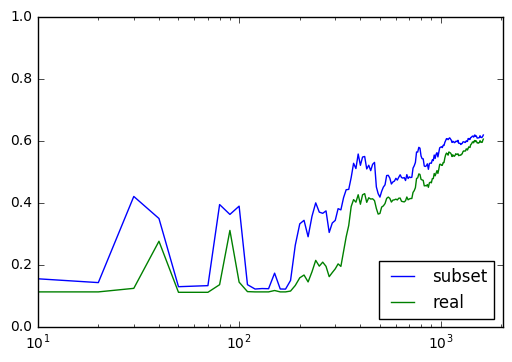

In [ ]:
#RAndom sampling
c = TextAI(False)
c.load_database("news")
c.process_text()
c.classify()


In [ ]:
#Active learning
c = TextAI(active=True)
c.load_database("news")
c.process_text()
c.classify()

